In [98]:
# upload audio file

path = '../audio_files/long_audio_2_mono.wav'

In [89]:
num_speakers = 2 #@param {type:"integer"}

language = 'English' #@param ['any', 'English']

model_size = 'large' #@param ['tiny', 'base', 'small', 'medium', 'large']


model_name = model_size
if language == 'English' and model_size != 'large':
  model_name += '.en'

In [6]:
%pip install -q git+https://github.com/openai/whisper.git > /dev/null
%pip install -q git+https://github.com/pyannote/pyannote-audio > /dev/null
%pip install -U speechbrain==0.5.16

import whisper
import datetime

import subprocess

import torch
import pyannote.audio
import speechbrain
from pyannote.audio.pipelines.speaker_verification import PretrainedSpeakerEmbedding
embedding_model = PretrainedSpeakerEmbedding(
    "speechbrain/spkrec-ecapa-voxceleb",
    device=torch.device("cuda"))

from pyannote.audio import Audio
from pyannote.core import Segment

import wave
import contextlib

from sklearn.cluster import AgglomerativeClustering
import numpy as np

2502.56s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Note: you may need to restart the kernel to use updated packages.


2521.67s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Note: you may need to restart the kernel to use updated packages.


2536.88s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


torchvision is not available - cannot save figures


In [99]:
if path[-3:] != 'wav':
  subprocess.call(['ffmpeg', '-i', path, 'long_audio_2_mono.wav', '-y'])
  path = 'long_audio_2_mono.wav'

In [91]:
model = whisper.load_model(model_size)

In [100]:
result = model.transcribe(path)
segments = result["segments"]

In [101]:
with contextlib.closing(wave.open(path,'r')) as f:
  frames = f.getnframes()
  rate = f.getframerate()
  duration = frames / float(rate)

In [103]:
audio = Audio()

def segment_embedding(segment):
  start = segment["start"]
  # Whisper overshoots the end timestamp in the last segment
  end = min(duration, segment["end"])
  clip = Segment(start, end)
  waveform, sample_rate = audio.crop(path, clip)
  print(waveform.shape)
    # Check if the waveform has more than one channel
  if waveform.shape[0] > 1:
   # Take the mean of the channels to create a mono waveform
     waveform = waveform.mean(axis=0)
     print(waveform.shape)
  # Add an extra dimension to the waveform array
     waveform = waveform[None, :]
     print( waveform.shape)
  return embedding_model(waveform[None])

In [104]:
embeddings = np.zeros(shape=(len(segments), 192))
for i, segment in enumerate(segments):
  embeddings[i] = segment_embedding(segment)

embeddings = np.nan_to_num(embeddings)

torch.Size([1, 447174])
torch.Size([1, 219618])
torch.Size([1, 283122])
torch.Size([1, 109368])
torch.Size([1, 256662])
torch.Size([1, 276066])
torch.Size([1, 131417])
torch.Size([1, 367794])
torch.Size([1, 49392])
torch.Size([1, 342216])
torch.Size([1, 107604])
torch.Size([1, 410130])
torch.Size([1, 73205])
torch.Size([1, 188748])
torch.Size([1, 109369])
torch.Size([1, 411013])
torch.Size([1, 223146])


In [106]:
clustering = AgglomerativeClustering(num_speakers).fit(embeddings)
labels = clustering.labels_
for i in range(len(segments)):
  segments[i]["speaker"] = 'SPEAKER ' + str(labels[i] + 1)

In [107]:
def time(secs):
  return datetime.timedelta(seconds=round(secs))

f = open("transcript.txt", "w")
x = ""
for (i, segment) in enumerate(segments):
  if i == 0 or segments[i - 1]["speaker"] != segment["speaker"]:
    f.write("\n" + segment["speaker"] + ' ' + str(time(segment["start"])) + '\n')
  f.write(segment["text"][1:] + ' ')
  x += "\n" + segment["speaker"] + ' ' + str(time(segment["start"])) + '\n'
  x += segment["text"][1:] + ' '
f.close()

In [108]:
print(open('transcript.txt').read())


SPEAKER 1 0:00:00
It's very hot today, isn't it? 
SPEAKER 2 0:00:11
Yes, it's so hot. It looks like summer is officially starting. 
SPEAKER 1 0:00:18
I'll have to remember to buy some sunblock then. My name is John, by the way. I'm Yumi. Nice to meet you. Nice to meet you, too. Are you from around here? 
SPEAKER 2 0:00:34
No, I'm from Hokkaido in Japan. It's much colder than here, even in summer. What's the weather like in your hometown at this time of year? 
SPEAKER 1 0:00:46
I'm from London. It rains a lot there, so I'm not used to these summer temperatures. Oh, really? 
SPEAKER 2 0:00:57
I like summer because we can go and spend time at the beach. I take my dog every time. He loves to run into the sea. What do you normally do in the summer in London? 
SPEAKER 1 0:01:09
If it's sunny, we often meet up and have picnics in the park. London has some really nice parks. Have you ever been there? 
SPEAKER 2 0:01:23
I've never been there, but I've always wanted to visit the museums. What d

In [109]:
print(x)


SPEAKER 1 0:00:00
It's very hot today, isn't it? 
SPEAKER 2 0:00:11
Yes, it's so hot. It looks like summer is officially starting. 
SPEAKER 1 0:00:18
I'll have to remember to buy some sunblock then. My name is John, by the way. 
SPEAKER 1 0:00:25
I'm Yumi. Nice to meet you. 
SPEAKER 1 0:00:27
Nice to meet you, too. Are you from around here? 
SPEAKER 2 0:00:34
No, I'm from Hokkaido in Japan. It's much colder than here, even in summer. 
SPEAKER 2 0:00:42
What's the weather like in your hometown at this time of year? 
SPEAKER 1 0:00:46
I'm from London. It rains a lot there, so I'm not used to these summer temperatures. 
SPEAKER 1 0:00:55
Oh, really? 
SPEAKER 2 0:00:57
I like summer because we can go and spend time at the beach. I take my dog every time. He loves to run into the sea. 
SPEAKER 2 0:01:06
What do you normally do in the summer in London? 
SPEAKER 1 0:01:09
If it's sunny, we often meet up and have picnics in the park. London has some really nice parks. 
SPEAKER 1 0:01:20
Have 

In [110]:
print(result)

{'text': " It's very hot today, isn't it? Yes, it's so hot. It looks like summer is officially starting. I'll have to remember to buy some sunblock then. My name is John, by the way. I'm Yumi. Nice to meet you. Nice to meet you, too. Are you from around here? No, I'm from Hokkaido in Japan. It's much colder than here, even in summer. What's the weather like in your hometown at this time of year? I'm from London. It rains a lot there, so I'm not used to these summer temperatures. Oh, really? I like summer because we can go and spend time at the beach. I take my dog every time. He loves to run into the sea. What do you normally do in the summer in London? If it's sunny, we often meet up and have picnics in the park. London has some really nice parks. Have you ever been there? I've never been there, but I've always wanted to visit the museums. What do people do in their free time there? People often go to watch football games at the weekend. Everyone is very passionate about their favorit

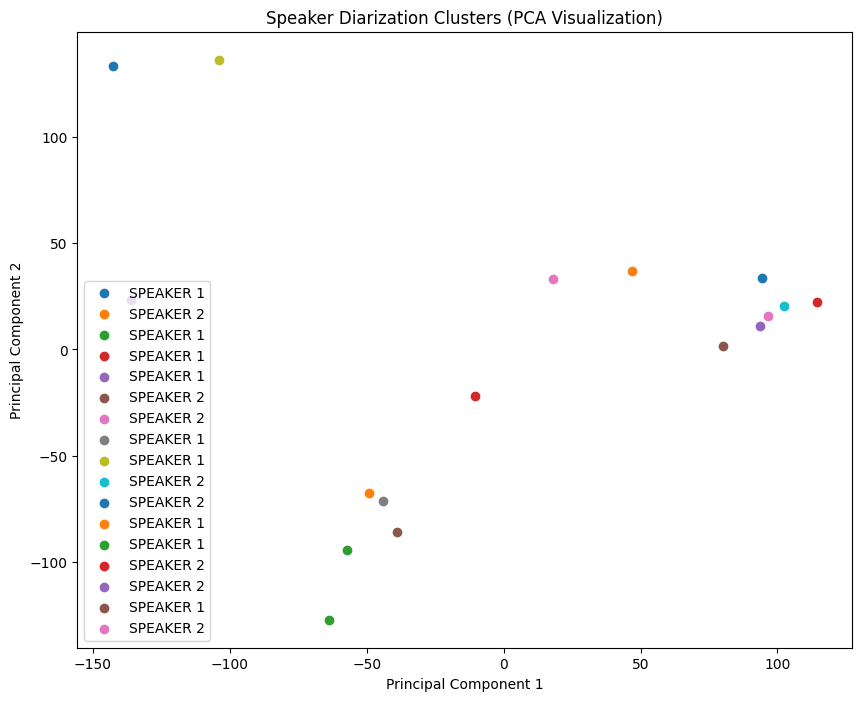

In [111]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Your existing code for clustering and labeling segments...

# Perform PCA to reduce the dimensionality of embeddings to 2D
pca = PCA(n_components=2, random_state=42)
embeddings_2d = pca.fit_transform(embeddings)

# Plot the clusters
plt.figure(figsize=(10, 8))
for i, segment in enumerate(segments):
    speaker_id = labels[i] + 1
    x, y = embeddings_2d[i]
    plt.scatter(x, y, label=f'SPEAKER {speaker_id}')

plt.title("Speaker Diarization Clusters (PCA Visualization)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()


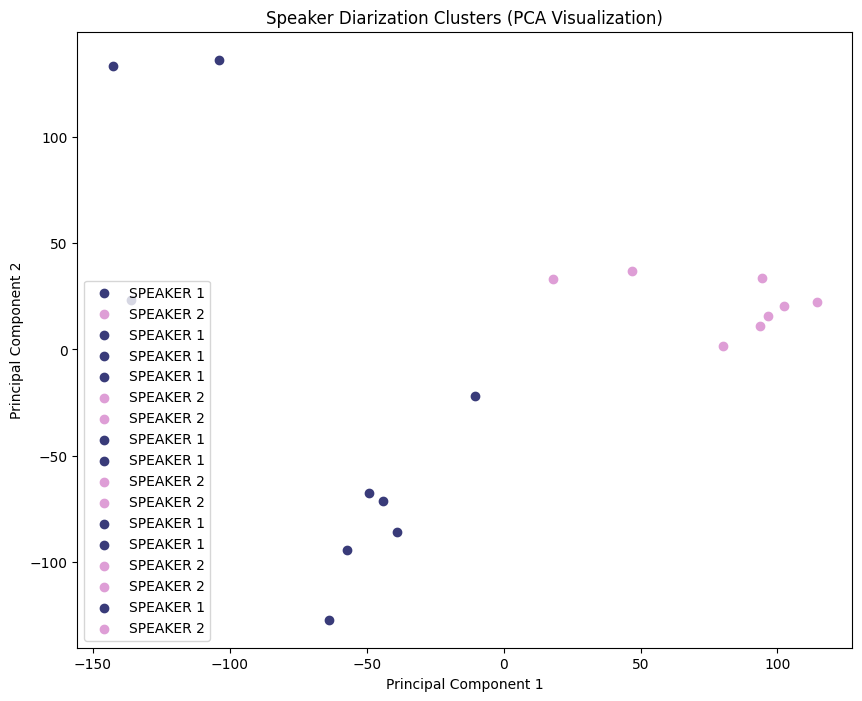

In [112]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.cm as cm

# Your existing code for clustering and labeling segments...

# Perform PCA to reduce the dimensionality of embeddings to 2D
pca = PCA(n_components=2, random_state=42)
embeddings_2d = pca.fit_transform(embeddings)

# Get the number of unique speakers from the labels
num_unique_speakers = len(np.unique(labels))

# Create a colormap for speakers, ensuring each speaker gets a unique color
colors = cm.tab20b(np.linspace(0, 1, num_unique_speakers))

# Plot the clusters
plt.figure(figsize=(10, 8))
for i, segment in enumerate(segments):
    speaker_id = labels[i] + 1
    x, y = embeddings_2d[i]
    color = colors[labels[i] % num_unique_speakers]  # Get the corresponding color for the speaker
    plt.scatter(x, y, label=f'SPEAKER {speaker_id}', color=color)

plt.title("Speaker Diarization Clusters (PCA Visualization)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()


In [86]:
import numpy as np
import plotly.graph_objects as go
from sklearn.decomposition import PCA
import matplotlib.cm as cm

# Your existing code for clustering and labeling segments...

# Perform PCA to reduce the dimensionality of embeddings to 3D
pca = PCA(n_components=3, random_state=42)
embeddings_3d = pca.fit_transform(embeddings)

# Get the number of unique speakers from the labels
num_unique_speakers = len(np.unique(labels))

# Create a colormap for speakers, ensuring each speaker gets a unique color
colors = cm.tab20b(np.linspace(0, 1, num_unique_speakers))

# Prepare the data for the 3D scatter plot
data = []
for i, segment in enumerate(segments):
    speaker_id = labels[i] + 1
    x, y, z = embeddings_3d[i]
    color = colors[labels[i] % num_unique_speakers]  # Get the corresponding color for the speaker
    trace = go.Scatter3d(x=[x], y=[y], z=[z], mode='markers',
                         marker=dict(size=5, color=color),
                         name=f'SPEAKER {speaker_id}')
    data.append(trace)

# Layout for the 3D scatter plot
layout = go.Layout(
    title="Speaker Diarization Clusters (3D Visualization)",
    scene=dict(
        xaxis_title="Principal Component 1",
        yaxis_title="Principal Component 2",
        zaxis_title="Principal Component 3"
    )
)

# Create the figure and plot the 3D scatter plot
fig = go.Figure(data=data, layout=layout)
fig.show()


ModuleNotFoundError: No module named 'plotly'